#  Build a Planet using BurnMan

Copyright (C) 2012 - 2022 by the BurnMan team, released under the GNU GPL v2 or later.
Released under GPL v2 or later.

This practical borrows heavily from a burnman tutorial developed mainly by Robert Myhill. 



For Earth we have well-constrained one-dimensional density models.  This allows us to
calculate pressure as a function of depth.  Furthermore, petrologic data and assumptions
regarding the convective state of the planet allow us to estimate the temperature.

For planets other than Earth we have much less information, and in particular we
know almost nothing about the pressure and temperature in the interior.  Instead, we tend
to have measurements of things like mass, radius, and moment-of-inertia.  We would like
to be able to make a model of the planet's interior that is consistent with those
measurements.

However, there is a difficulty with this.  In order to know the density of the planetary
material, we need to know the pressure and temperature.  In order to know the pressure,
we need to know the gravity profile.  And in order to the the gravity profile, we need
to know the density.  This is a nonlinear problem which requires us to iterate to find
a self-consistent solution.

This example allows the user to define layers of planets of known outer radius and self-
consistently solve for the density, pressure and gravity profiles. The calculation will
iterate until the difference between central pressure calculations are less than 1e-5.
The planet class in BurnMan (../burnman/planet.py) allows users to call multiple
properties of the model planet after calculations, such as the mass of an individual layer,
the total mass of the planet and the moment if inertia. See planets.py for information
on each of the parameters which can be called.


*Uses:*

* :doc:`mineral_database`
* :class:`burnman.planet.Planet`
* :class: `burnman.layer.Layer`

*Demonstrates:*

* setting up a planet
* computing its self-consistent state
* computing various parameters for the planet
* seismic comparison



### Build Mars

For Mars, we now have some seismic observations to add as additional constraint to the mantle structure, besides mass and moment-of-inertia. 

The setup below will build an earthlike planet. It is your goal to change this into Mars. 

Constraints you might need to think of:
 - What are the mass and moment-of-intertia for Mars? 
 - Where is the core-mantle boundary on Mars? 
 - Does Mars have an inner core? 
 - Are Martian mantle pressures sufficient to have a lower mantle? 
 - What sort of seismic constraints can be added for Mars?
 
 Steps to take:
 1. Study the Earth model, and make improvements if you wish. 
 2. Collect constraints on Mars, some papers to look at are listed below. 
 3. Make a copy of this jupyter notebook for Mars, implement the new constraints. 
 4. Adapt the planet to fit Martian constraints. 
 
  - Seismic constraints on Mars' mantle: Khan, et al. , Upper mantle structure of Mars from InSight seismic data, Science, 373, 6553, (434-438), (2021).
  - Seismic constraints on Mars' core: Stähler, et al., Seismic detection of the martian core, Science, 373, 6553, (443-448), (2021).
  - Mars compositional model: Yoshizaki, T. and McDonough, W.F., 2021. Earth and Mars–distinct inner solar system products. Geochemistry, 81(2), p.125746.
  


### Imports
Run the imports once

In [1]:
%matplotlib inline
import os,sys

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

if './burnman_1.1' not in sys.path:
    sys.path.insert(0,'./burnman_1.1')
print(sys.path)
import burnman
print(burnman.__version__)

import obspy
from obspy.taup import TauPyModel
from obspy.taup import taup_create

from burnman import Mineral, PerplexMaterial, Composite, Layer, Planet
from burnman import minerals
from burnman import Composition
from burnman.tools.chemistry import formula_mass
from burnman import BoundaryLayerPerturbation

        

['./burnman_1.1', '/Volumes/GoogleDrive/My Drive/Teaching/Part3_option_2022/Practical/Git_versions/Mars', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python38.zip', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/lib-dynload', '', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/IPython/extensions', '/Users/sanne/.ipython']
1.1.0pre


### Defining Layers
First, we must define the composition of the planet as individual layers.
A layer is defined by 4 parameters: Name, min_depth, max_depth,and number of slices within the layer.
Separately the composition and the temperature_mode need to set.

In [7]:
planet_radius = 6371.e3



# Compositions from midpoints of Hirose et al. (2021), ignoring carbon and hydrogen
inner_core_composition = Composition({'Fe': 94.4, 'Ni': 5., 'Si': 0.55, 'O': 0.05}, 'weight')
outer_core_composition = Composition({'Fe': 90., 'Ni': 5., 'Si': 2., 'O': 3.}, 'weight')


for c in [inner_core_composition, outer_core_composition]:
    c.renormalize('atomic', 'total', 1.)

inner_core_elemental_composition = dict(inner_core_composition.atomic_composition)
outer_core_elemental_composition = dict(outer_core_composition.atomic_composition)
inner_core_molar_mass = formula_mass(inner_core_elemental_composition)
outer_core_molar_mass = formula_mass(outer_core_elemental_composition)

### Inner Core
icb_radius = 1220.e3
inner_core = Layer('inner core', radii=np.linspace(0., icb_radius, 21))


# We don't have exact seismic models for such compositions, so modify a model for solid iron. 
# Note: no shear modulus is given for this model, which means our S wave velocity is set to zero in the inner core. 
# And our P wave velocity is the same as the bulk sound velocity. 
hcp_iron = minerals.SE_2015.hcp_iron()
params = hcp_iron.params

# This liquid iron's volume is modified to fit PREM
params['name'] = 'modified solid iron'
params['formula'] = inner_core_elemental_composition
params['molar_mass'] = inner_core_molar_mass
delta_V = 2.3e-7

inner_core_material = Mineral(params=params,
                              property_modifiers=[['linear',
                                                   {'delta_E': 0.,
                                                    'delta_S': 0.,
                                                    'delta_V': delta_V}]])

# check that the new inner core material does what we expect:
hcp_iron.set_state(200.e9, 4000.)
inner_core_material.set_state(200.e9, 4000.)
assert np.abs(delta_V - (inner_core_material.V - hcp_iron.V)) < 1.e-12

inner_core.set_material(inner_core_material)
# Set adiabatic temperature profile
inner_core.set_temperature_mode('adiabatic')


### Outer Core
cmb_radius = 3480.e3
outer_core = Layer('outer core', radii=np.linspace(icb_radius, cmb_radius, 21))

# This liquid iron's volume is modified to fit PREM
liq_iron = minerals.SE_2015.liquid_iron()
params = liq_iron.params

params['name'] = 'modified liquid iron'
params['formula'] = outer_core_elemental_composition
params['molar_mass'] = outer_core_molar_mass
delta_V = -2.0e-7
outer_core_material = Mineral(params=params,
                              property_modifiers=[['linear',
                                                   {'delta_E': 0.,
                                                    'delta_S': 0.,
                                                    'delta_V': delta_V}]])

# check that the new inner core material does what we expect:
liq_iron.set_state(200.e9, 4000.)
outer_core_material.set_state(200.e9, 4000.)
assert np.abs(delta_V - (outer_core_material.V - liq_iron.V)) < 1.e-12

outer_core.set_material(outer_core_material)
# Set adiabatic temperature profile
outer_core.set_temperature_mode('adiabatic')


### Lower Mantle
top_lm_radius = 5371.e3
lower_mantle = burnman.Layer('lower mantle', radii = np.linspace(cmb_radius, top_lm_radius, 10))

# A lower_mantle layer of bridgmanite:ferropericlase:Ca-pervoskite in 75:18:7 molar proportions
# Perovksite (bridgmanite) solid solution
frac_mg = 0.9
frac_fe = 0.1
frac_al = 0.00
mg_fe_perovskite = minerals.SLB_2011.mg_fe_perovskite()
mg_fe_perovskite.set_composition([frac_mg, frac_fe, frac_al])

# Ferropericlase solid solution
frac_mg = 0.8
frac_fe = 0.2
mg_fe_periclase = minerals.SLB_2011.ferropericlase()
mg_fe_periclase.set_composition([frac_mg,frac_fe])
    
# Ca Perovskite
ca_perovskite = minerals.SLB_2011.ca_perovskite()

# Pyrolitic composition
pyr_pv = 0.75
pyr_fp = 0.18
pyr_capv = 0.07
pyrolitic_mantle = burnman.Composite(
        [mg_fe_perovskite, mg_fe_periclase, ca_perovskite], [pyr_pv, pyr_fp, pyr_capv], name = 'Pyrolitic')


# set lower mantle composition
lower_mantle.set_material(pyrolitic_mantle)

#An adiabatic profile with the top temperature taken from the layer above. 
# A perturbation is applied for the thermal boundary layer in the lowermost mantle. 
tbl_perturbation = BoundaryLayerPerturbation(radius_bottom=cmb_radius,
                                             radius_top=top_lm_radius,
                                             rayleigh_number=1.e7,
                                             temperature_change=900.,
                                             boundary_layer_ratio=40./900.)
lower_mantle.set_temperature_mode('perturbed-adiabatic', tbl_perturbation.temperature(lower_mantle.radii))


### Upper Mantle
base_lithos_radius = 6171.e3
upper_mantle = burnman.Layer('upper mantle', radii = np.linspace(top_lm_radius, base_lithos_radius, 10))
# This is a very simplified composition of olivine with 8% Fe. 
olivine= minerals.SLB_2011.mg_fe_olivine(molar_fractions=[0.92, 0.08])
upper_mantle.set_material(olivine)
# Adiabatic temperature profile
upper_mantle.set_temperature_mode('adiabatic')


### Lithosphere
moho_radius = 6341.e3
# A very simplified composition of Olivine with 6% Fe
dunite = minerals.SLB_2011.mg_fe_olivine(molar_fractions=[0.94, 0.06])
lithospheric_mantle = Layer('lithospheric mantle',
                            radii=np.linspace(base_lithos_radius, moho_radius, 31))
lithospheric_mantle.set_material(dunite)

# A linear temperature profile
lab_temperature = 1550.
moho_temperature = 620.
lithospheric_mantle.set_temperature_mode('user-defined',
                                         np.linspace(lab_temperature,
                                                     moho_temperature, 31))

### Crust
# A simple plagioclase composition
andesine = minerals.SLB_2011.plagioclase(molar_fractions=[0.4, 0.6])
crust = Layer('crust', radii=np.linspace(moho_radius, planet_radius, 11))
crust.set_material(andesine)

# A linear temperature profile
surface_temperature = 300.
crust.set_temperature_mode('user-defined',
                           np.linspace(moho_temperature,
                                       surface_temperature, 11))

### Making a self-consistent planet
Now we stitch the planet together

In [8]:
planet_zog = burnman.Planet('Planet_Zog',
                            [inner_core, outer_core, lower_mantle, upper_mantle, lithospheric_mantle, crust],
                            verbose=True)
print(planet_zog)


Planet_Zog consists of 6 layers:
The inner core is made of modified solid iron with adiabatic temperatures and self-consistent pressures
The outer core is made of modified liquid iron with adiabatic temperatures and self-consistent pressures
The lower mantle is made of Pyrolitic with perturbed-adiabatic temperatures and self-consistent pressures
The upper mantle is made of olivine with adiabatic temperatures and self-consistent pressures
The lithospheric mantle is made of olivine with user-defined temperatures and self-consistent pressures
The crust is made of plagioclase with user-defined temperatures and self-consistent pressures



Here we compute its state, this is where all the work gets done. Go BurnMan Go!
(If we were to change composition of one of the layers, we would have to
recompute the state)

In [9]:
planet_zog.make()


Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.5e-01
Iteration 3 maximum relative pressure error: 1.7e-01
Iteration 4 maximum relative pressure error: 6.4e-02
Iteration 5 maximum relative pressure error: 2.3e-02
Iteration 6 maximum relative pressure error: 8.3e-03
Iteration 7 maximum relative pressure error: 3.0e-03
Iteration 8 maximum relative pressure error: 1.1e-03
Iteration 9 maximum relative pressure error: 3.8e-04
Iteration 10 maximum relative pressure error: 1.4e-04
Iteration 11 maximum relative pressure error: 4.9e-05
Iteration 12 maximum relative pressure error: 1.8e-05
Iteration 13 maximum relative pressure error: 6.3e-06


### Showing results
Now we can output the mass of the planet and moment of inertia

In [10]:
print('\nmass/Earth= {0:.3f}, moment of inertia factor= {1:.4f} (for Earth: 0.3307)'.format(planet_zog.mass / 5.97e24,
                                                                      planet_zog.moment_of_inertia_factor))


mass/Earth= 0.979, moment of inertia factor= 0.3269 (for Earth: 0.3307)


Or the mass of the individual layers

In [14]:
for layer in planet_zog.layers:
    print('{0} mass fraction of planet {1:.3f}'.format(layer.name, layer.mass / planet_zog.mass))  
print('')

inner core mass fraction of planet 0.017
outer core mass fraction of planet 0.315
lower mantle mass fraction of planet 0.405
upper mantle mass fraction of planet 0.209
lithospheric mantle mass fraction of planet 0.047
crust mass fraction of planet 0.007



Let's get PREM to compare everything to as we are trying
to imitate Earth

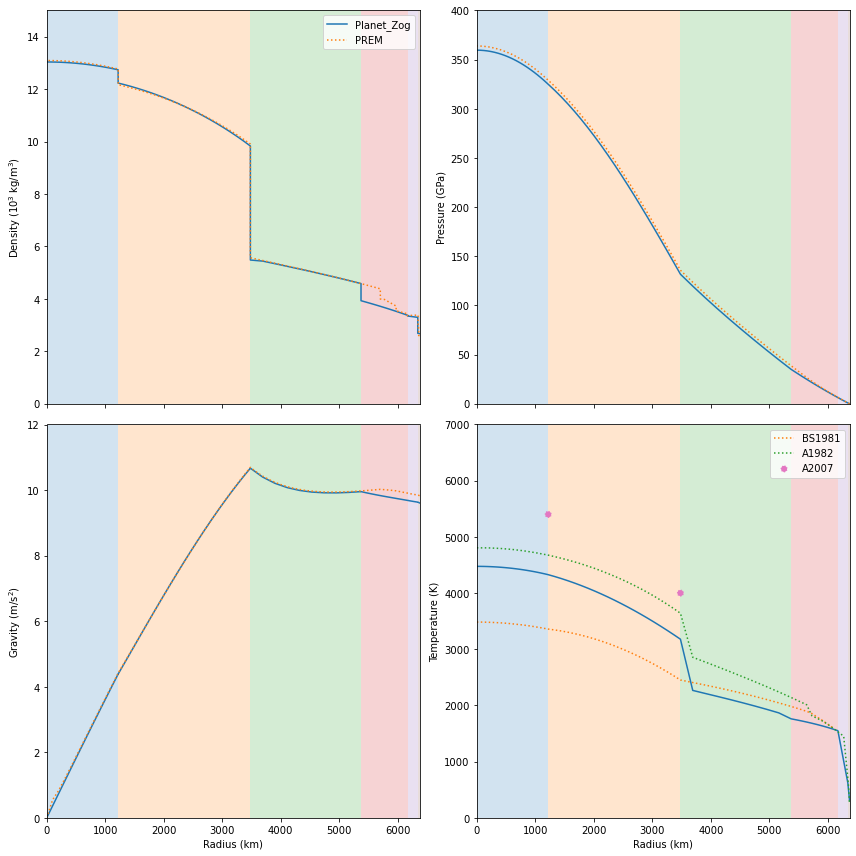

In [12]:
prem = burnman.seismic.PREM()
premradii = 6371.e3 - prem.internal_depth_list()
premdensity, prempressure, premgravity,premvs,premvp = prem.evaluate(
    ['density', 'pressure', 'gravity', 'v_s','v_p'])


fig = plt.figure(figsize=(12, 12))
ax = [fig.add_subplot(2, 2, i) for i in range(1, 5)]


bounds = np.array([[layer.radii[0]/1.e3, layer.radii[-1]/1.e3]
                   for layer in planet_zog.layers])
maxy = [15, 400, 12, 7000]
for bound in bounds:
    for i in range(4):
        ax[i].fill_betweenx([0., maxy[i]],
                            [bound[0], bound[0]],
                            [bound[1], bound[1]], alpha=0.2)

ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3,
           label=planet_zog.name)
ax[0].plot(premradii / 1.e3, premdensity / 1.e3, linestyle=':', label='PREM')
ax[0].set_ylabel('Density ($10^3$ kg/m$^3$)')
ax[0].legend()

# Make a subplot showing the calculated pressure profile
ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9)
ax[1].plot(premradii / 1.e3, prempressure / 1.e9, linestyle=':')
ax[1].set_ylabel('Pressure (GPa)')

# Make a subplot showing the calculated gravity profile
ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity)
ax[2].plot(premradii / 1.e3, premgravity, linestyle=':')
ax[2].set_ylabel('Gravity (m/s$^2)$')
ax[2].set_xlabel('Radius (km)')

# Make a subplot showing the calculated temperature profile
ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature)
ax[3].set_ylabel('Temperature (K)')
ax[3].set_xlabel('Radius (km)')
ax[3].set_ylim(0.,)

# Finally, let's overlay some geotherms onto our model
# geotherm
labels = ['Brown and Shankland (1981)',
          'Anderson (1982)',
          'Alfe et al. (2007)']

short_labels = ['BS1981',
                'A1982',
                'A2007']


mask = planet_zog.depth > 269999.
ax[3].plot(planet_zog.radii[mask] / 1.e3,
           burnman.geotherm.brown_shankland(planet_zog.depth[mask]),
           linestyle=':', label=short_labels[0])
ax[3].plot(planet_zog.radii / 1.e3,
           burnman.geotherm.anderson(planet_zog.depth),
           linestyle=':', label=short_labels[1])

ax[3].scatter([planet_zog.layers[0].radii[-1] / 1.e3,
               planet_zog.layers[1].radii[-1] / 1.e3],
              [5400., 4000.],
              linestyle=':', label=short_labels[2])


ax[3].legend()

for i in range(2):
    ax[i].set_xticklabels([])
for i in range(4):
    ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)
    ax[i].set_ylim(0., maxy[i])

fig.set_tight_layout(True)
plt.show()

    

### Plotting ray paths and predicted travel times

First we need to build the correct input file for obspy.

In [ ]:
# Write out a tvel file
burnman.tools.output_seismo.write_tvel_file(planet_zog, modelname=planet_zog.name)
# Build a taup_model for Obspy
taup_create.build_taup_model(
            "./" + planet_zog.name + ".tvel", ".")

Arrivals to plot, some random examples of phase names to use ("P","S", "PcP", "Sdiff", "SKS", "PKIKP") <br>
Phase naming in obspy.taup is explained at
https://docs.obspy.org/packages/obspy.taup.html
Here we plot differential times between surface multiples and direct phases. 

In [ ]:
phase_list = ["P", "S", "PP", "SS", "ScS"]
source_depth = 10 # in km
min_degrees = 20 # minimum distance for ray paths
max_degrees = 90 # maximum distance for ray paths
npoints = 16 # number of distances to plot ray paths
ref_model = 'prem' # choice of models available in obpsy, or input an npz file name


# Time to plot some predictions using routines from Obspy
plt.figure(figsize=[14, 14])
ax = plt.subplot(2, 2, 1)

# Load models
taup_planet_zog = TauPyModel(model=planet_zog.name +'.npz')
taup_prem = TauPyModel(model="PREM")

# plotting predicted travel times at all distances
dists = np.linspace(min_degrees, max_degrees, npoints)
all_arrvs_zog = dict()
all_arrvs_prem = dict()
for ph in phase_list: 
    all_arrvs_zog[ph] =np.empty_like(dists)
    all_arrvs_prem[ph] =np.empty_like(dists)
for d, dist in enumerate(dists): 
    for ph in phase_list:
        arrs = taup_planet_zog.get_travel_times(source_depth_in_km = source_depth, 
                                         distance_in_degree=dist, 
                                         phase_list=[ph])

        if len(arrs)>0: 
            all_arrvs_zog[ph][d]=arrs[0].time
            
        else:
            all_arrvs_zog[ph][d]=np.nan

        arrs = taup_prem.get_travel_times(source_depth_in_km = source_depth, 
                                         distance_in_degree=dist, 
                                         phase_list=[ph])

        if len(arrs)>0: 
            all_arrvs_prem[ph][d]=arrs[0].time
        else:
            all_arrvs_prem[ph][d]=np.nan
            
plt.plot(all_arrvs_zog['S']-all_arrvs_zog['P'], all_arrvs_zog['PP']-all_arrvs_zog['P'],'r', label = 'PP-P')
plt.plot(all_arrvs_prem['S']-all_arrvs_prem['P'], all_arrvs_prem['PP']-all_arrvs_prem['P'],'k')
plt.plot(all_arrvs_zog['S']-all_arrvs_zog['P'], all_arrvs_zog['SS']-all_arrvs_zog['P'],'g', label = 'SS-P')
plt.plot(all_arrvs_prem['S']-all_arrvs_prem['P'], all_arrvs_prem['SS']-all_arrvs_prem['P'],'k')
plt.plot(all_arrvs_zog['S']-all_arrvs_zog['P'], all_arrvs_zog['ScS']-all_arrvs_zog['P'],'m', label = 'ScS-P')
plt.plot(all_arrvs_prem['S']-all_arrvs_prem['P'], all_arrvs_prem['ScS']-all_arrvs_prem['P'],'k', label='PREM ref')

plt.xlabel('S-P times')
plt.ylabel('differential times times')


plt.legend()

